# Evidence Transfer

In [1]:
import wandb

FOLDS = 2
wandb.init(project='evidence-transfer', config={
    'unet_loss': 'categorical_crossentropy',
    'connecting_unet_layer': 'expanding_block_64_conv2',
    'q_loss': 'binary_crossentropy',
    'q_lambda': 0.1,
    'optimizer': 'adam',
    'learning_rate': 1e-5,
    'momentum': 0.9,
    'batch_size': 3,
    'dataset': f'folds{FOLDS}',
    'max_epochs': 5
})
hparams = wandb.config

wandb: Currently logged in as: vassilis_krikonis (use `wandb login --relogin` to force relogin)
/usr/local/lib/python3.6/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
from models.unet import create_unet
from models.evitram import create_evidence_transfer_model
import tensorflow as tf

unet = create_unet()
unet.load_weights('model-best_0.h5')

q_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(1, (1, 1), padding='same', activation='sigmoid'),
], name='Q')

evitram = create_evidence_transfer_model(
    unet,
    q_model,
    'expanding_block_64_conv2',
    loss_lambda=hparams['q_lambda']
)

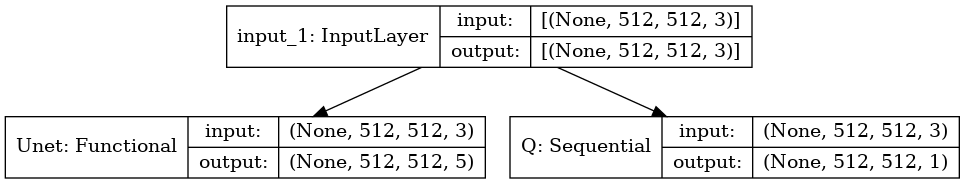

In [3]:
import tensorflow as tf

tf.keras.utils.plot_model(evitram, show_layer_names=True, show_shapes=True)

In [4]:
from metrics import CategoricalMeanIou
from tensorflow.keras.optimizers import SGD, Adam

if hparams['optimizer'] == 'sgd':
    optimizer = SGD(learning_rate=hparams['learning_rate'], momentum=hparams['momentum'])
elif hparams['optimizer'] == 'adam':
    optimizer = Adam(learning_rate=hparams['learning_rate'])
else:
    optimizer = hparams['optimizer']

evitram.compile(optimizer=optimizer, metrics=[
    [CategoricalMeanIou(num_classes=5), 'accuracy'],
    ['accuracy']
])

In [5]:
!mkdir -p /tmp/ds_cache/
from datasets.skyline12 import Skyline12

skyline12 = Skyline12('datasets/skyline12/data/')


def split_outputs(x, y, z):
    return x, (y, z)


train_ds = skyline12 \
    .as_tf_dataset(FOLDS, subset='training', cache_dir='/tmp/ds_cache/') \
    .map(split_outputs)
val_ds = skyline12 \
    .as_tf_dataset(FOLDS, subset='validation', cache_dir='/tmp/ds_cache/') \
    .map(split_outputs)

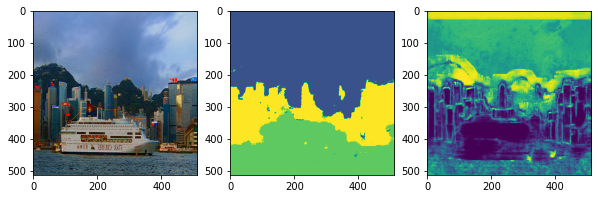

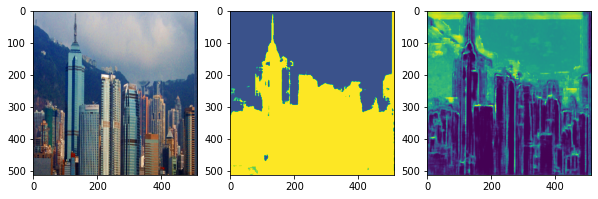

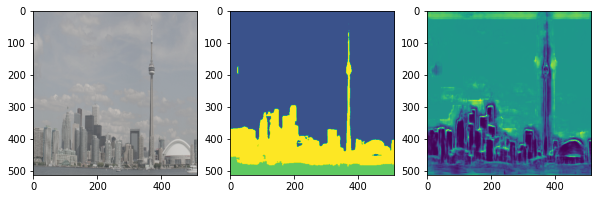

In [6]:
batch_x, _ = next(iter(val_ds.batch(3)))
preds = evitram(batch_x, training=False)

for x, y_pred, z_pred in zip(batch_x, *preds):
    Skyline12.show_sample(x, [y_pred, z_pred], from_tensors=True)

In [7]:
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.data.experimental import AUTOTUNE
from utils import get_new_logdir
from callbacks import LogEviTRAMImagesWandb
from wandb.keras import WandbCallback

log_dir = get_new_logdir(root_dir='./logs')
batch_size = 3
evitram.fit(
    train_ds.batch(batch_size).prefetch(AUTOTUNE),
    epochs=hparams['max_epochs'],
    validation_data=val_ds.batch(batch_size).prefetch(AUTOTUNE),
    callbacks=[
        TensorBoard(
            log_dir=log_dir,
            histogram_freq=1,
        ),
        LogEviTRAMImagesWandb(next(iter(val_ds.batch(10)))),
        WandbCallback(save_weights_only=True)
    ]
)

Epoch 1/5
      6/Unknown - 14s 765ms/step - loss: 0.4212 - Unet_categorical_mean_iou: 0.4662 - Unet_accuracy: 0.8490 - Q_accuracy: 0.4927WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.2290s vs `on_train_batch_end` time: 0.3979s). Check your callbacks.
80/80 [==============================] - 66s 709ms/step - loss: 0.3070 - Unet_categorical_mean_iou: 0.5801 - Unet_accuracy: 0.9134 - Q_accuracy: 0.5376 - val_loss: 0.4016 - val_Unet_categorical_mean_iou: 0.5289 - val_Unet_accuracy: 0.9241 - val_Q_accuracy: 0.6517
Epoch 2/5
80/80 [==============================] - 53s 666ms/step - loss: 0.2932 - Unet_categorical_mean_iou: 0.5820 - Unet_accuracy: 0.9150 - Q_accuracy: 0.6548 - val_loss: 0.3846 - val_Unet_categorical_mean_iou: 0.5286 - val_Unet_accuracy: 0.9248 - val_Q_accuracy: 0.7686
Epoch 3/5
80/80 [==============================] - 53s 667ms/step - loss: 0.2832 - Unet_categorical_mean_iou: 0.5832 - Unet_accuracy: 0.9163 - Q_accur

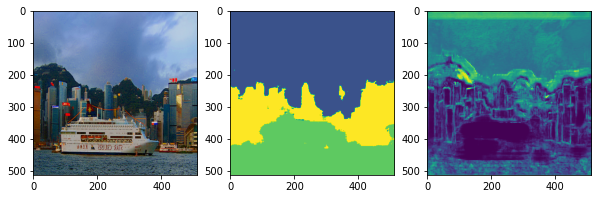

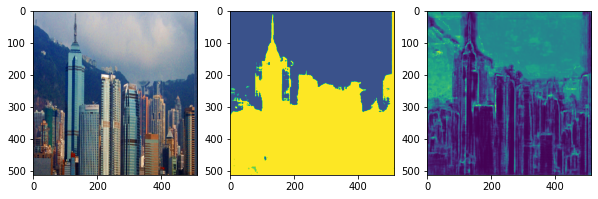

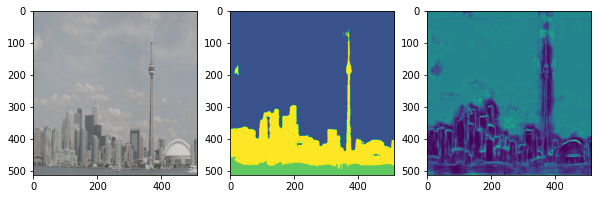

In [8]:
batch_x, _ = next(iter(val_ds.batch(3)))
preds = evitram(batch_x, training=False)

for x, y_pred, z_pred in zip(batch_x, *preds):
    Skyline12.show_sample(x, [y_pred, z_pred], from_tensors=True)

In [9]:
wandb.run.finish()

epoch,4
loss,0.21679
Unet_categorical_mean_iou,0.61267
Unet_accuracy,0.93154
Q_accuracy,0.86922
val_loss,0.35605
val_Unet_categorical_mean_iou,0.52948
val_Unet_accuracy,0.92654
val_Q_accuracy,0.8858
_step,4
_runtime,341


epoch,▁▃▅▆█
loss,█▆▄▃▁
Unet_categorical_mean_iou,▁▄▆▇█
Unet_accuracy,▁▃▅▇█
Q_accuracy,▁▄▆▇█
val_loss,█▅▃▂▁
val_Unet_categorical_mean_iou,▃▁▂▅█
val_Unet_accuracy,▁▃▅▆█
val_Q_accuracy,▁▄▆▇█
_step,▁▃▅▆█
_runtime,▁▃▄▆█
